In [3]:
import os
import rasterio

def check_tif_consistency(tif_path):
    """校验单个TIFF文件的元数据"""
    try:
        with rasterio.open(tif_path) as src:
            return {
                'width': src.width,
                'height': src.height,
                'crs': src.crs.to_string() if src.crs else None,  # 转换CRS为字符串
                'transform': tuple(src.transform),
                'nodata': src.nodata
            }
    except Exception as e:
        print(f"无法打开文件 {tif_path}: {str(e)}")
        return None

# 主程序
folder_path = r"D:\MachineLearningTrain2\bbbb"
all_files = os.listdir(folder_path)
tif_files = [os.path.join(folder_path, f) for f in all_files if f.endswith('.tif')]

# 指定基准文件的绝对路径
base_file = os.path.join(folder_path, "distance_to_road.tif")  # 确保文件名与实际一致

# 校验基准文件
base_meta = check_tif_consistency(base_file)
if not base_meta:
    raise FileNotFoundError("基准文件不存在或无法读取")

# 批量校验其他文件
for tif_file in tif_files:
    current_meta = check_tif_consistency(tif_file)
    if current_meta and current_meta != base_meta:
        print(f"文件 {os.path.basename(tif_file)} 元数据不一致：")
        for key in base_meta:
            if base_meta[key] != current_meta[key]:
                print(f"  {key}: 基准值={base_meta[key]} | 当前值={current_meta[key]}")

文件 curvature.tif 元数据不一致：
  transform: 基准值=(29.17340694116189, 0.0, 402897.5852273693, 0.0, -29.173406941161943, 3066259.313639992, 0.0, 0.0, 1.0) | 当前值=(29.17340694116189, 0.0, 402897.58522736933, 0.0, -29.173406941161943, 3066259.313639992, 0.0, 0.0, 1.0)
文件 elev_med.tif 元数据不一致：
  transform: 基准值=(29.17340694116189, 0.0, 402897.5852273693, 0.0, -29.173406941161943, 3066259.313639992, 0.0, 0.0, 1.0) | 当前值=(29.17340694116189, 0.0, 402897.58522736933, 0.0, -29.173406941161943, 3066259.313639992, 0.0, 0.0, 1.0)
文件 jiangshui.tif 元数据不一致：
  transform: 基准值=(29.17340694116189, 0.0, 402897.5852273693, 0.0, -29.173406941161943, 3066259.313639992, 0.0, 0.0, 1.0) | 当前值=(29.17340694116189, 0.0, 402897.5852273693, 0.0, -29.173406941161943, 3066259.3136399924, 0.0, 0.0, 1.0)
文件 ndvi.tif 元数据不一致：
  transform: 基准值=(29.17340694116189, 0.0, 402897.5852273693, 0.0, -29.173406941161943, 3066259.313639992, 0.0, 0.0, 1.0) | 当前值=(29.17340694116189, 0.0, 402897.58522736933, 0.0, -29.173406941161943, 3066259.3136

In [4]:
import os
import rasterio
import numpy as np
import pandas as pd
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling as ResampleMethod

def safe_resample(src, base_meta):
    """安全重采样函数（含NoData处理）"""
    # 继承原始无效值属性
    src_nodata = src.nodata if src.nodata else -9999
    dst_nodata = base_meta.get('nodata', src_nodata)
    
    # 修正初始化方式（关键参数顺序）
    dst_data = np.full((base_meta['height'], base_meta['width']), 
                      fill_value=dst_nodata, 
                      dtype=base_meta['dtype'])
    
    # 执行重投影（显式传递nodata参数）
    reproject(
        source=rasterio.band(src, 1),
        destination=dst_data,
        src_transform=src.transform,
        src_crs=src.crs,
        src_nodata=src_nodata,
        dst_transform=base_meta['transform'],
        dst_crs=base_meta['crs'],
        dst_nodata=dst_nodata,
        resampling=ResampleMethod.bilinear
    )
    return np.where(dst_data == dst_nodata, np.nan, dst_data)  # 替换为NaN

# 主程序
folder_path = r"D:\MachineLearningTrain2\bbbb"
tif_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]

# 动态获取基准元数据
with rasterio.open(os.path.join(folder_path, tif_files[0])) as base_src:
    base_meta = {
        'crs': base_src.crs,
        'transform': base_src.transform,
        'height': base_src.height,
        'width': base_src.width,
        'dtype': base_src.dtypes[0],
        'nodata': base_src.nodata
    }

array_list = []
file_names = []
for tif_file in tif_files:
    file_path = os.path.join(folder_path, tif_file)
    try:
        with rasterio.open(file_path) as src:
            # 智能判断是否需要重采样
            if (src.crs != base_meta['crs']) or (src.transform != base_meta['transform']):
                processed_data = safe_resample(src, base_meta)
            else:
                processed_data = src.read(1)
                processed_data[processed_data == src.nodata] = np.nan  # 原始数据替换NaN
            
            # 有效性检查
            if np.all(np.isnan(processed_data)):
                raise ValueError("处理后数据全为NaN")
                
            array_list.append(processed_data.flatten())
            file_names.append(os.path.splitext(tif_file)[0])
    except Exception as e:
        print(f"处理 {tif_file} 失败: {str(e)}")
        continue


merged = np.vstack(array_list)
transposed = merged.T
df = pd.DataFrame(transposed, columns=file_names)
    
# 替换弃用的fillna语法（改用ffill方法）
df = df.ffill()  # 前向填充替代 fillna(method='ffill')
    
# 剔除全无效行
#df = df.dropna(how='all')
df = df.reset_index(drop=True)  # 删除旧索引，生成新索引
df

,curvature,distance_to_road,distance_to_water,elev_med,jiangshui,ndvi,宜黄dem
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
4084295,0.117497,0.071984,0.269472,-35.0,1745.663574,0.786525,442.0
4084296,0.117497,0.071984,0.269472,-35.0,1745.663574,0.786525,442.0
4084297,0.117497,0.071984,0.269472,-35.0,1745.663574,0.786525,442.0
4084298,0.117497,0.071984,0.269472,-35.0,1745.663574,0.786525,442.0


In [5]:
# 在主程序末尾添加：
print(f"基准栅格尺寸：{base_meta['width']}x{base_meta['height']}")
print(f"处理后数据行数：{len(df)}")  # 应等于 width*height

基准栅格尺寸：1580x2585
处理后数据行数：4084300


In [6]:
# 查看各特征列的缺失值数量
missing_count = df.isnull().sum()
print("各特征缺失值统计：\n", missing_count)

# 查看总缺失值占比
total_missing = df.isnull().sum().sum()
total_cells = df.size
print(f"\n总缺失值占比：{total_missing/total_cells:.2%}")

各特征缺失值统计：
 curvature            11956
distance_to_road     11956
distance_to_water    11956
elev_med             11956
jiangshui            11956
ndvi                 11956
宜黄dem                11956
dtype: int64

总缺失值占比：0.29%


In [7]:
df = df.fillna(0)  # 均值填充  df.mean()

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()#实例化
label=['curvature','宜黄dem','distance_to_road','distance_to_water','ndvi','jiangshui','elev_med']
df[label] = scaler.fit_transform(df[label])
df

,curvature,distance_to_road,distance_to_water,elev_med,jiangshui,ndvi,宜黄dem
0,0.016209,-1.252976,-1.388100,-0.057663,-15.455832,-9.892506,-1.578457
1,0.016209,-1.252976,-1.388100,-0.057663,-15.455832,-9.892506,-1.578457
2,0.016209,-1.252976,-1.388100,-0.057663,-15.455832,-9.892506,-1.578457
3,0.016209,-1.252976,-1.388100,-0.057663,-15.455832,-9.892506,-1.578457
4,0.016209,-1.252976,-1.388100,-0.057663,-15.455832,-9.892506,-1.578457
...,...,...,...,...,...,...,...
4084295,0.126808,2.091699,2.046423,-0.225246,-0.180724,0.540766,0.192503
4084296,0.126808,2.091699,2.046423,-0.225246,-0.180724,0.540766,0.192503
4084297,0.126808,2.091699,2.046423,-0.225246,-0.180724,0.540766,0.192503
4084298,0.126808,2.091699,2.046423,-0.225246,-0.180724,0.540766,0.192503


In [9]:
# 曲率的绝对值：负曲率（山谷）和正曲率（山脊）可能对滑坡贡献不同
df['curvature_abs'] = np.abs(df['curvature'])

In [10]:
df = df.rename(columns={
    'elev_med': 'elevation_diff',
    'jiangshui': 'yihuangjia'
})

In [11]:
df

,curvature,distance_to_road,distance_to_water,elevation_diff,yihuangjia,ndvi,宜黄dem,curvature_abs
0,0.016209,-1.252976,-1.388100,-0.057663,-15.455832,-9.892506,-1.578457,0.016209
1,0.016209,-1.252976,-1.388100,-0.057663,-15.455832,-9.892506,-1.578457,0.016209
2,0.016209,-1.252976,-1.388100,-0.057663,-15.455832,-9.892506,-1.578457,0.016209
3,0.016209,-1.252976,-1.388100,-0.057663,-15.455832,-9.892506,-1.578457,0.016209
4,0.016209,-1.252976,-1.388100,-0.057663,-15.455832,-9.892506,-1.578457,0.016209
...,...,...,...,...,...,...,...,...
4084295,0.126808,2.091699,2.046423,-0.225246,-0.180724,0.540766,0.192503,0.126808
4084296,0.126808,2.091699,2.046423,-0.225246,-0.180724,0.540766,0.192503,0.126808
4084297,0.126808,2.091699,2.046423,-0.225246,-0.180724,0.540766,0.192503,0.126808
4084298,0.126808,2.091699,2.046423,-0.225246,-0.180724,0.540766,0.192503,0.126808


In [13]:
def swap_columns(df, col1, col2):
    """交换两列数据及列名"""
    # 数据交换
    df[[col1, col2]] = df[[col2, col1]].values  
    # 列名调换
    df = df.rename(columns={col1: col2, col2: col1})
    return df
#调换顺序，与模型训练时一致
# 调用示例
df = swap_columns(df, 'curvature_abs', 'curvature')
df = swap_columns(df, 'elevation_diff', 'distance_to_road')
df = swap_columns(df, 'distance_to_water', '宜黄dem')
df = swap_columns(df, 'distance_to_water', 'distance_to_road')
df = swap_columns(df, 'distance_to_road', 'yihuangjia')
df

,curvature,distance_to_water,yihuangjia,宜黄dem,distance_to_road,ndvi,elevation_diff,curvature_abs
0,0.016209,-1.388100,-15.455832,-1.578457,-1.252976,-9.892506,-0.057663,0.016209
1,0.016209,-1.388100,-15.455832,-1.578457,-1.252976,-9.892506,-0.057663,0.016209
2,0.016209,-1.388100,-15.455832,-1.578457,-1.252976,-9.892506,-0.057663,0.016209
3,0.016209,-1.388100,-15.455832,-1.578457,-1.252976,-9.892506,-0.057663,0.016209
4,0.016209,-1.388100,-15.455832,-1.578457,-1.252976,-9.892506,-0.057663,0.016209
...,...,...,...,...,...,...,...,...
4084295,0.126808,2.046423,-0.180724,0.192503,2.091699,0.540766,-0.225246,0.126808
4084296,0.126808,2.046423,-0.180724,0.192503,2.091699,0.540766,-0.225246,0.126808
4084297,0.126808,2.046423,-0.180724,0.192503,2.091699,0.540766,-0.225246,0.126808
4084298,0.126808,2.046423,-0.180724,0.192503,2.091699,0.540766,-0.225246,0.126808


In [14]:
df.drop(columns=['curvature','RFC'], inplace=True,errors='ignore')
df

,distance_to_water,yihuangjia,宜黄dem,distance_to_road,ndvi,elevation_diff,curvature_abs
0,-1.388100,-15.455832,-1.578457,-1.252976,-9.892506,-0.057663,0.016209
1,-1.388100,-15.455832,-1.578457,-1.252976,-9.892506,-0.057663,0.016209
2,-1.388100,-15.455832,-1.578457,-1.252976,-9.892506,-0.057663,0.016209
3,-1.388100,-15.455832,-1.578457,-1.252976,-9.892506,-0.057663,0.016209
4,-1.388100,-15.455832,-1.578457,-1.252976,-9.892506,-0.057663,0.016209
...,...,...,...,...,...,...,...
4084295,2.046423,-0.180724,0.192503,2.091699,0.540766,-0.225246,0.126808
4084296,2.046423,-0.180724,0.192503,2.091699,0.540766,-0.225246,0.126808
4084297,2.046423,-0.180724,0.192503,2.091699,0.540766,-0.225246,0.126808
4084298,2.046423,-0.180724,0.192503,2.091699,0.540766,-0.225246,0.126808


In [16]:
df = swap_columns(df, 'curvature_abs', 'distance_to_water')
df = swap_columns(df, 'elevation_diff', 'yihuangjia')
df = swap_columns(df, 'distance_to_water', 'distance_to_road')
df = swap_columns(df, 'yihuangjia', 'ndvi')
df = swap_columns(df, 'distance_to_road', 'yihuangjia')
df

,curvature_abs,elevation_diff,宜黄dem,distance_to_water,distance_to_road,ndvi,yihuangjia
0,0.016209,-0.057663,-1.578457,-1.388100,-1.252976,-9.892506,-15.455832
1,0.016209,-0.057663,-1.578457,-1.388100,-1.252976,-9.892506,-15.455832
2,0.016209,-0.057663,-1.578457,-1.388100,-1.252976,-9.892506,-15.455832
3,0.016209,-0.057663,-1.578457,-1.388100,-1.252976,-9.892506,-15.455832
4,0.016209,-0.057663,-1.578457,-1.388100,-1.252976,-9.892506,-15.455832
...,...,...,...,...,...,...,...
4084295,0.126808,-0.225246,0.192503,2.046423,2.091699,0.540766,-0.180724
4084296,0.126808,-0.225246,0.192503,2.046423,2.091699,0.540766,-0.180724
4084297,0.126808,-0.225246,0.192503,2.046423,2.091699,0.540766,-0.180724
4084298,0.126808,-0.225246,0.192503,2.046423,2.091699,0.540766,-0.180724


In [17]:
import numpy as np
import pandas as pd
import joblib
from sklearn.base import is_classifier


# 加载模型
model_path = 'best_model.pkl'
model = joblib.load(model_path)
print(f"已加载模型：{type(model).__name__}")

# 分块参数配置
CHUNK_SIZE = 50000  # 根据内存调整，单块内存建议<500MB
DTYPE = 'float32'    # 统一使用低精度类型[4,11](@ref)

# 将现有DataFrame转换为分块迭代器[7](@ref)
def dataframe_chunker(df, chunk_size):
    """将内存中的DataFrame分块生成"""
    for start in range(0, len(df), chunk_size):
        end = start + chunk_size
        yield df.iloc[start:end].astype(DTYPE)  # 强制类型转换[11](@ref)

# 分块处理主逻辑
with open('prob.csv', 'w') as f:  # 初始化输出文件
    f.write('Class_0_Probability,Class_1_Probability\n')

for i, chunk in enumerate(dataframe_chunker(df, CHUNK_SIZE)):
    # 分块填充缺失值（使用本块均值）[9](@ref)
    chunk = pd.DataFrame(
        np.nan_to_num(chunk.values, nan=np.nanmean(chunk, axis=0)),
        columns=chunk.columns,
        dtype=DTYPE
    )
    
    # 并行预测（需模型支持）[8](@ref)
    if hasattr(model, 'n_jobs'):
        model.n_jobs = -1  # 启用全CPU核心[8](@ref)
    
    # 执行预测并保存
    probs = model.predict_proba(chunk)
    pd.DataFrame(probs, columns=['Class_0_Probability','Class_1_Probability'])\
      .to_csv('prob.csv', mode='a', header=False, index=False)
    
    # 内存释放与进度跟踪
    del chunk, probs
    print(f"进度：{min((i+1)*CHUNK_SIZE, len(df))}/{len(df)}行")

已加载模型：RandomForestClassifier
进度：50000/4084300行
进度：100000/4084300行
进度：150000/4084300行
进度：200000/4084300行
进度：250000/4084300行
进度：300000/4084300行
进度：350000/4084300行
进度：400000/4084300行
进度：450000/4084300行
进度：500000/4084300行
进度：550000/4084300行
进度：600000/4084300行
进度：650000/4084300行
进度：700000/4084300行
进度：750000/4084300行
进度：800000/4084300行
进度：850000/4084300行
进度：900000/4084300行
进度：950000/4084300行
进度：1000000/4084300行
进度：1050000/4084300行
进度：1100000/4084300行
进度：1150000/4084300行
进度：1200000/4084300行
进度：1250000/4084300行
进度：1300000/4084300行
进度：1350000/4084300行
进度：1400000/4084300行
进度：1450000/4084300行
进度：1500000/4084300行
进度：1550000/4084300行
进度：1600000/4084300行
进度：1650000/4084300行
进度：1700000/4084300行
进度：1750000/4084300行
进度：1800000/4084300行
进度：1850000/4084300行
进度：1900000/4084300行
进度：1950000/4084300行
进度：2000000/4084300行
进度：2050000/4084300行
进度：2100000/4084300行
进度：2150000/4084300行
进度：2200000/4084300行
进度：2250000/4084300行
进度：2300000/4084300行
进度：2350000/4084300行
进度：2400000/4084300行
进度：2450000/4084300行
进度：2500000/

In [18]:
import pandas as pd

# 读取 CSV 文件
file_path = 'prob.csv'  # 替换为你的文件名
df = pd.read_csv(file_path)

# 删除指定列
column_to_delete = 'Class_0_Probability'  # 替换为你想删除的列名
df.drop(columns=[column_to_delete], inplace=True)
df

,Class_1_Probability
0,0.319643
1,0.319643
2,0.319643
3,0.319643
4,0.319643
...,...
4084295,0.546732
4084296,0.546732
4084297,0.546732
4084298,0.546732


In [19]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin

# 提取概率数据
values = df.iloc[:, 0].values
# 在主程序末尾添加：
print(f"基准栅格尺寸：{base_meta['height']}x{base_meta['width']}")
print(f"处理后数据行数：{len(df)}")  # 应等于 width*height
len(values)


基准栅格尺寸：2585x1580
处理后数据行数：4084300


4084300

In [21]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin

# 提取概率数据
values = df.iloc[:, 0].values


# 确保数据维度匹配
#if len(values) !=  base_meta['height']*base_meta['width'] :
#    raise ValueError("CSV数据与栅格尺寸不匹配")
    
    
# 在转换为二维数组前添加裁剪逻辑
target_pixels = base_meta['height'] * base_meta['width']
if len(values) > target_pixels:
    values = values[:target_pixels]  # 截断多余数据
elif len(values) < target_pixels:
    values = np.pad(values, (0, target_pixels - len(values)), mode='edge')  # 边缘填充
# 读取栅格信息
with rasterio.open(r"D:\MachineLearningTrain2\bbbb\宜黄dem.tif") as src:
    profile = src.profile.copy()
    num_cols = src.width
    num_rows = src.height
    transform = src.transform
# 转换为二维数组
raster_data = values.reshape((base_meta['height'], base_meta['width'])).astype(np.float32)

# 更新profile
profile.update(
    dtype=rasterio.float32,
    count=1
)

# 保存为新的TIFF文件
output_raster = r"D:\MachineLearningTrain2\bbb\RFC.tif"
with rasterio.open(output_raster, 'w', **profile) as dst:
    dst.write(raster_data, 1)

print("栅格文件已成功保存！")

栅格文件已成功保存！


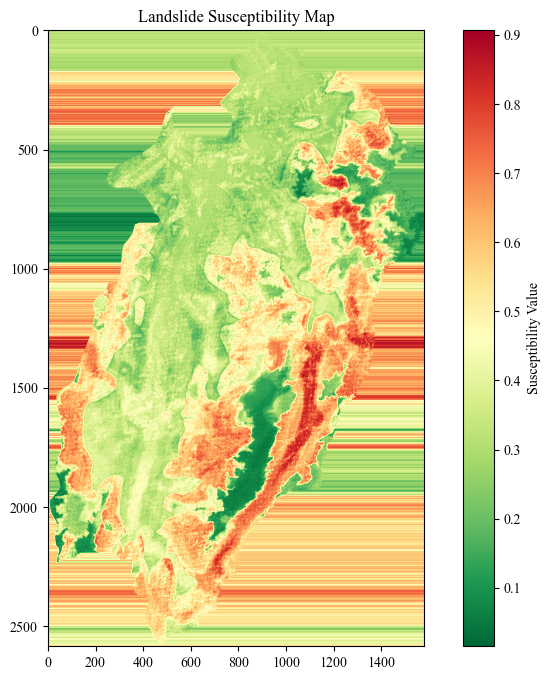

In [22]:
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False
# 读取栅格数据
raster_path = r"D:\MachineLearningTrain2\bbb\RFC.tif"
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)
    profile = src.profile

# 将无效值替换为NaN，便于处理
raster_data = np.where(raster_data == profile['nodata'], np.nan, raster_data)

# 可视化栅格数据，使用从绿到红的色带
plt.figure(figsize=(10, 8))
cmap = plt.cm.RdYlGn_r  # 直接从plt.cm中获取色带
plt.imshow(raster_data, cmap=cmap)
plt.colorbar(label='Susceptibility Value')
plt.title('Landslide Susceptibility Map')
plt.savefig('Landslide Susceptibility MapRFC.png')
plt.show()

In [23]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 1. 读取DEM栅格数据
dem_path = r"D:\MachineLearningTrain2\bbbb\宜黄dem.tif"
with rasterio.open(dem_path) as src:
    dem = src.read(1)  # 读取第一波段
    transform = src.transform  # 仿射变换参数
    nodata = src.nodata   # 获取无效值标记

    # === 关键: 从transform计算地理坐标系范围 ===
    # 计算地理坐标范围 [left, right, bottom, top]
    width = src.width
    height = src.height
    left = transform[2]
    top = transform[5]
    right = left + transform[0] * width
    bottom = top + transform[4] * height

# 2. DEM数据预处理
dem = np.where(dem == nodata, np.nan, dem)  # 替换无效值为NaN

# 3. 地形特征计算（示例：坡度+曲率综合模型）
#---------------------------
# 使用RichDem库高效计算地形属性（需安装：pip install richdem）
import richdem as rd

dem_array = rd.rdarray(dem, no_data=np.nan)  # 创建RichDem对象
slope = rd.TerrainAttribute(dem_array, attrib='slope_radians')  # 坡度（弧度）
curvature = rd.TerrainAttribute(dem_array, attrib='curvature')  # 曲率

# 标准化特征到0-1范围
slope_norm = (slope - np.nanmin(slope)) / (np.nanmax(slope) - np.nanmin(slope))
curvature_norm = (curvature - np.nanmin(curvature)) / (np.nanmax(curvature) - np.nanmin(curvature))

# 综合易发性指标（此处简化模型，可替换为机器学习模型结果）
susceptibility = 0.6 * slope_norm + 0.4 * curvature_norm

# 4. 易发性结果归一化到0.1~0.9（与示例图匹配）
susceptibility = (susceptibility - np.nanmin(susceptibility)) * (0.9-0.1)/(
    np.nanmax(susceptibility) - np.nanmin(susceptibility)) + 0.1

# 5. 专业可视化
#---------------------------
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

# 自定义绿-红渐变色带 (类似示例图)
colors = ["#006400", "#B4EEB4", "#FFFF00", "#FF4500", "#8B0000"]  # 深绿→浅绿→黄→橙红→暗红
cmap = LinearSegmentedColormap.from_list("custom_risk", colors, N=256)

# 绘制栅格数据（使用地理坐标范围）
im = ax.imshow(susceptibility, 
               cmap=cmap, 
               extent=[left, right, bottom, top],  # 地理坐标轴
               vmin=0.1,  # 固定色带范围
               vmax=0.9)

# 添加颜色条 (与示例图一致)
cbar = fig.colorbar(im, ax=ax, label='Landslide Susceptibility', 
                   ticks=np.linspace(0.1, 0.9, 9))
cbar.set_ticklabels([f"{v:.1f}" for v in np.linspace(0.1, 0.9, 9)])

# 标注坐标轴
ax.set_xlabel('Horizontal Distance (m)', fontsize=12)
ax.set_ylabel('Elevation (m)', fontsize=12)
ax.set_title('Landslide Susceptibility Map of Yihuang County', fontsize=14, pad=20)

plt.tight_layout()
plt.savefig('Landslide_Susceptibility_Map_DEM_Based.png', bbox_inches='tight')
plt.show()

ModuleNotFoundError: No module named 'richdem'